In [1]:
#!/usr/bin/env python3

import sys
import pandas as pd
import datetime
import requests
import numpy as np
from pandas import ExcelWriter
import os
import glob
import pytz
from dateutil.tz import gettz
import timeit
# from datetime import datetime
from datetime import timedelta
import time


In [3]:


#

def read_data(devid, acc_token, address, start_time, end_time, descriptors):


    r2 = requests.get(
        url=address + "/api/plugins/telemetry/DEVICE/" + devid + "/values/timeseries?keys=" + descriptors + "&startTs=" + start_time + "&endTs=" + end_time + "&agg=NONE&limit=1000000",
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()

    if r2:
        df = pd.DataFrame([])

        for desc in r2.keys():
            df1 = pd.DataFrame(r2[desc])
            df1.set_index('ts', inplace=True)
            df1.columns = [str(desc)]
            df = pd.concat([df, df1], axis=1)


        if df.empty == False:

            df.reset_index(drop=False, inplace=True)
            df = df.sort_values(by=['ts'])
            df.reset_index(drop=True, inplace=True)
            df.set_index('ts', inplace=True, drop=True)
            for col in df.columns:
                df[col] = df[col].astype('float')

            df = df.groupby(df.index).max()

        else:
            df = pd.DataFrame([])
    else:
        df = pd.DataFrame([])
        print('Empty json!')
    return df







In [ ]:

devid = '4353f360-98d6-11ea-8d54-4d0d5d00237b'
descriptors = 'pwrA,pwrB,pwrC,apwrA,apwrB,apwrC,rpwrA,rpwrB,rpwrC'
start_time = [1589749200000]
end_time = [1589835599999]

for i in range(1,11):
    start_time.append(end_time[i-1]+1)
    end_time.append(end_time[i-1]+86400000)


for i in range(9,10):
    filename = '../../Desktop/windowsshare/stelios_data/house_data/data_day_'+str(i)+'.csv'

    address = "http://52.77.235.183:8080"

    r = requests.post(address + "/api/auth/login",
                      json={'username': 'tenant@thingsboard.org', 'password': 'tenant'}).json()

    # acc_token is the token to be used in the next request
    acc_token = 'Bearer' + ' ' + r['token']


    timediff = int(end_time[i])-int(start_time[i])

    # if difference between end and start time is greater than 5 minutes, split data 
    if timediff<900000:
        summary = read_data(devid, acc_token, address, str(start_time[i]), str(end_time[i]), descriptors)

        if not summary.empty:
            summary.to_csv(filename, index=True)
    else:
        #print('time requested larger than 5 minutes...')
        svec = np.arange(int(start_time[i]),int(end_time[i]),900000)
        for st in svec:
            en = st+900000-1

            if int(end_time[i])-en<=0: en = int(end_time[i])
    #         print('start and end of iteration:',st,en)

            summary = read_data(devid, acc_token, address, str(st), str(en), descriptors)
            if not summary.empty:
                if os.path.isfile(filename)==False:
                    summary.to_csv(filename, index=True)
                else:
                    summary.to_csv(filename, index=True,mode='a', header=False)



In [16]:
#### download plug data from m3

devid = 'd5ab7e20-61f1-11ea-9dd1-ab3b9dbab99c'
descriptors = 'pwrA'
start_time = [1591909200000] #12/6/2020
end_time = [1591995600000]



address = "https://m3.meazon.com"

r = requests.post(address + "/api/auth/login",
                  json={'username': 'meazon@thingsboard.org', 'password': 'meazon'}).json()

# acc_token is the token to be used in the next request
acc_token = 'Bearer' + ' ' + r['token']
summary = read_data(devid, acc_token, address, str(start_time[0]), str(end_time[0]), descriptors)
summary['ts'] = pd.to_datetime(summary.index,utc=True, unit='ms')
summary['ts'] = summary['ts'].dt.tz_convert('Europe/Athens')

summary.set_index('ts',inplace=True, drop=True)
# summary = summary.resample('1S').mean()

summary.head()

,pwrA
ts,
2020-06-12 00:00:57+03:00,0.139
2020-06-12 00:01:57+03:00,0.122
2020-06-12 00:02:57+03:00,0.140
2020-06-12 00:03:57+03:00,0.145
2020-06-12 00:04:57+03:00,0.135


Text(0.5, 1.0, 'Washing machine operation monitored with plug')

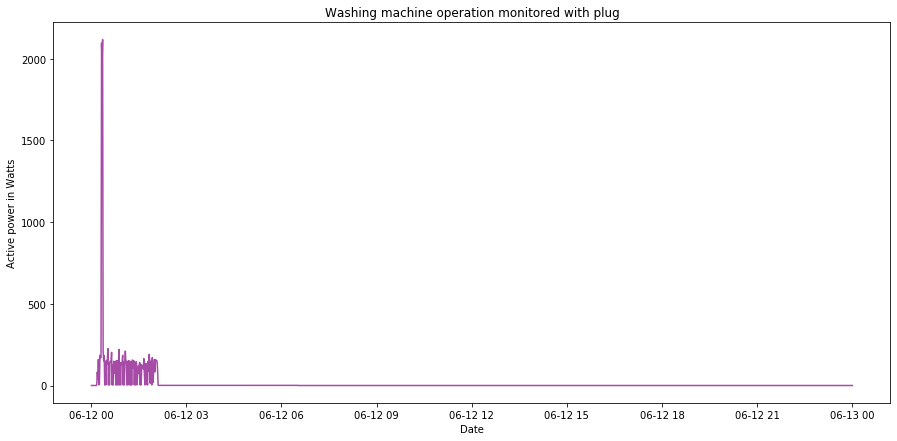

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=[15,7])
plt.plot(summary.index,summary['pwrA'],'purple',alpha=0.7)#,df2.index,df2['rpwrB'])
plt.xlabel('Date')
plt.ylabel('Active power in Watts')
plt.title('Washing machine operation monitored with plug')